In [3]:
import sys
from os import path
sys.path.append(path.dirname(path.dirname(path.abspath('model.py'))))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import model

In [5]:
from importlib import reload
reload(model);

# Load training data

In [6]:
# Load train data
TRAIN_PATH = '../../data/train_data.pkl'
train_noisy_imgs_input, train_noisy_imgs_target = torch.load(TRAIN_PATH)
train_noisy_imgs_input = train_noisy_imgs_input/255
train_noisy_imgs_target = train_noisy_imgs_target/255
print('training size: ', train_noisy_imgs_input.shape[0])
training_set_size, num_channels, y_size, x_size = train_noisy_imgs_input.shape

training size:  50000


In [7]:
# Load validation data
VALIDATION_PATH = '../../data/val_data.pkl'
validation_noisy_imgs, validation_clean_imgs = torch.load(VALIDATION_PATH)
validation_noisy_imgs = validation_noisy_imgs/255
validation_clean_imgs = validation_clean_imgs/255
print('validation size: ', validation_clean_imgs.shape[0])

validation size:  1000


## Our implementation

In [8]:
ourModel = model.Model()
ourModel.train(train_noisy_imgs_input, train_noisy_imgs_target, num_epochs=10, debug=True)

Doing epoch 0
0.04117876514792442
0.032151198387145995
0.028286859020590784
0.031979138031601906
0.021787920966744423
0.027022162079811098
0.021926043182611467
0.021784040704369546
0.02327844351530075
0.021464142948389053
0.023415980115532874
0.023616674169898034
0.02133065424859524
0.022844220325350762
0.020488439500331877
0.021904511749744414
0.020758087188005446
0.02082788199186325
0.0210253719240427
0.02082575559616089
0.02050214484333992
0.02068076655268669
0.020910343527793883
0.018666209280490877
0.01906098797917366
0.019490443170070648
0.02057097405195236
0.018393290415406226
0.01805912423878908
0.02075021117925644
0.02025299407541752
Doing epoch 1
0.012172171473503112
0.018797758594155313
0.019244901090860366
0.01942097768187523
0.01978815719485283
0.017075025662779807
0.01932992711663246
0.017191646993160246
0.019967355579137803
0.019392986595630646
0.01891300790011883
0.019230833277106285
0.01900826059281826
0.01906643956899643
0.02032032944262028
0.018526579067111016
0.0184

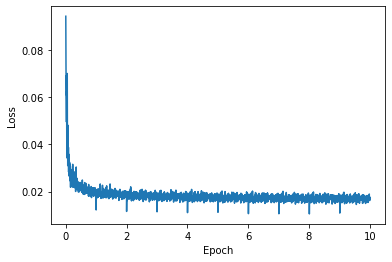

In [9]:
fig = plt.figure()
xs = np.arange(len(ourModel.losses)) / train_noisy_imgs_input.shape[0] * 32 * 5
plt.plot(xs, ourModel.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

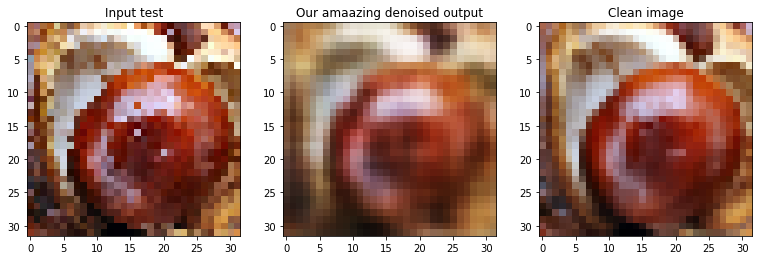

In [10]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 3
denoised = ourModel.predict(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr, :, :, :].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [11]:
def evaluate(denoised, target):
    mse = torch.mean((denoised - target) ** 2)
    return -10 * torch.log10(mse + 10**-8)

In [12]:
denoised = ourModel.predict(test_input)
evaluate(denoised, test_target)

tensor(22.3378)

In [13]:
torch.save(ourModel.model, 'bestmodel.pt')

## Torch implementation

In [14]:
torch.set_grad_enabled(True)
torch_model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 3, 3, padding=1),
            #   nn.Sigmoid()
            )

# optimizer = torch.optim.SGD(torch_model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adam(torch_model.parameters())
criterion = nn.MSELoss()

In [16]:
summary(torch_model, (3, 32, 32))

ModuleNotFoundError: No module named 'torch_summary'

In [ ]:
train_input = train_noisy_imgs_input
train_target = train_noisy_imgs_target
batch_size = 32
num_epochs = 5
avg_loss = 0
losses = []

for e in range(num_epochs):
    print('Doing epoch %d'%e)
    for b, (input, target) in enumerate(zip(train_input.split(batch_size),
                                            train_target.split(batch_size))):
        output = torch_model(input)
        loss = criterion(output, target)
        avg_loss += loss.item()

        # make step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        b_freq = 5
        if b % b_freq == 0 and (b+e) > 0:
            losses.append(avg_loss / b_freq)
            avg_loss = 0
            b % 50 == 0 and print(losses[-1])

In [ ]:
fig = plt.figure()
plt.plot(losses)
plt.xlabel('# batches/5')
plt.ylabel('loss')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.xlabel('# batches/5')
plt.ylabel('loss')
plt.show()

In [ ]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 1
denoised = torch_model(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [ ]:
denoised = torch_model(test_input)
evaluate(denoised, test_target)